Este material é um mix de material próprio, e material adaptado do livro texto da disciplina e do repositório do autor do livro (https://github.com/ageron/handson-ml)

Material de referência: livro do Géron, capítulo 4

# Modelos lineares

Até o momento vimos o processo de construção de uma solução de machine learning:

- Aquisição e preparo dos dados
- Definição da métrica de desempenho
- Separação em conjuntos de treinamento e teste
- Investigação dos dados
- Escolha de modelo:
    - Avaliação de vários modelos usando validação cruzada
    - Comparação de métricas de desempenho
    - Ajuste de hiperparâmetros
- Treinamento final
- Teste final
- Etapas de producão
    - Relatório final
    - Operacionalização do modelo em produção

Porém neste processo todo nossos modelos eram "caixas pretas", não conhecemos nada sobre como os modelos funcionam!

Nesta aula vamos começar a investigar os modelos lineares: o que são, e como treina-los. Vamos aprender sobre regressão linear, algoritmos de treinamento, regressão polinomial, overfitting versus underfitting. Na aula seguinte vamos discutir o *tradeoff bias/variance*, estratégias de regularização, regressão logística e softmax.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

RAND_SEED = 42

np.random.seed(RAND_SEED)

# Revisão

## Modelo

Em todo problema de machine learning uma amostra de entrada é um vetor 

$$\mathbf{x} = (x_1, x_2, \cdots, x_n) \in \mathbb{R}^{n}$$

de $n$ valores (características ou *features*) reais. (Valores categóricos tem que ser convertidos em valores reais usando codificação *one-hot*.)

Em notação matricial, os vetores são matrizes-coluna:

$$
\mathbf{x} = \left[
\begin{matrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{matrix}
\right]
\in \mathbb{R}^{n \times 1}
$$

Vamos trabalhar com as duas notações (vetores e matrizes-coluna) de modo intercambiável, e que ficará evidente no contexto de uso.

Uma amostra de saída é um valor que se supõe depender da entrada. Se o valor de saída é contínuo temos um problema de **regressão**, e se o valor é categórico (trata-se de uma classe ou categoria) temos um problema de **classificação**.

Um modelo de machine learning é uma função que permite estimar o valor de saída para uma dada amostra de entrada. Esta função depende de **parâmetros** $\mathbf{\theta}$, que representam os "ajustes" desta função. Ou seja:

$$y_{\text{estimado}} = \hat{y} = h_{\mathbf{\theta}}\left(\mathbf{x}\right)$$

## Erro

O objetivo principal em um projeto de machine learning é encontrar um modelo que produza boas estimativas, ou seja, estimativas que se aproximem dos valores reais. *Treinamento* é ajustar os parâmetros $\mathbf{\theta}$ para conseguir **em geral** melhores estimativas. (Ou seja, não é garantido que acerta em todos os casos, mas tenta estar *quase sempre próximo*.)

Uma estimativa é boa se o **erro** entre a estimativa e o valor real é baixo. A definição do erro depende do problema em questão. Se for uma regressão, então uma medida razoável de erro para uma dada amostra é a diferença entre o valor real e o valor estimado:

$$\text{erro}\left(\mathbf{x}, y, \mathbf{\theta} \right) = \hat{y} - y = h_{\mathbf{\theta}}\left(\mathbf{x}\right) - y$$

Se desejamos uma métrica positiva de erro, podemos adotar:

- o valor absoluto do erro: $\left| \,\text{erro}\left(\mathbf{x}, y, \mathbf{\theta} \right) \,\right|$, ou 
- o valor quadrático do erro: $\text{erro}\left(\mathbf{x}, y, \mathbf{\theta} \right)^2$

Se for um problema de classificação, então o erro pode ser simplesmente o resultado da comparação entre a classe real e a classe estimada. 

## Erro sobre um conjunto de amostras

Será que um modelo é bom? Uma forma de responder esta questão é avaliar o erro médio do classificador sobre um conjunto de exemplos. 

Para ilustrar essa ideia, vamos considerar um problema de regressão. Seja $\left(\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \cdots, \mathbf{x}^{(m)}\right)$ uma lista de $m$ amostras, e $\left(\mathbf{y}^{(1)}, \mathbf{y}^{(2)}, \cdots, \mathbf{y}^{(m)}\right)$ os valores dependentes correspondentes.

(Lembrando: $\mathbf{x}^{(i)} \in \mathbb{R}^{n \times 1}$ são matrizes-coluna em notação matricial, e $\mathbf{y}^{(i)} \in \mathbb{R}$ são valores reais.)

Vamos representar essa informação na forma de uma matriz $\mathbf{X}$ para as amostras e um vetor $\mathbf{y}$ para os valores dependentes, ou seja:

$$
\mathbf{X} = \left[
\begin{matrix} 
\left(\mathbf{x}^{(1)}\right)^{T} \\
\left(\mathbf{x}^{(2)}\right)^{T} \\
\vdots \\
\left(\mathbf{x}^{(m)}\right)^{T} \\
\end{matrix}
\right]
= \left[ 
\begin{matrix}
\mathbf{x}_{1}^{(1)} & \mathbf{x}_{2}^{(1)} & \cdots & \mathbf{x}_{n}^{(1)} \\
\mathbf{x}_{1}^{(2)} & \mathbf{x}_{2}^{(2)} & \cdots & \mathbf{x}_{n}^{(2)} \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{x}_{1}^{(m)} & \mathbf{x}_{2}^{(m)} & \cdots & \mathbf{x}_{n}^{(m)} \\
\end{matrix}
\right]

\  \text{,} \quad
\mathbf{y} = \left[
\begin{matrix}
\mathbf{y}^{(1)} \\
\mathbf{y}^{(2)} \\
\vdots \\
\mathbf{y}^{(m)} \\
\end{matrix}
\right]
$$

O erro quadrático médio é (surpresa!) a média do erro quadrático sobre o conjunto de amostras:

$$
\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right) = 
\frac{1}{m} \sum_{i=1}^{m} \left(h_{\mathbf{\theta}}\left(\mathbf{x}^{(i)}\right) - \mathbf{y}^{(i)}\right)^2
$$

É comum usarmos a raiz quadrada de $\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right)$, para que o erro esteja descrito nas mesmas unidades de medida da variável dependente. Obtemos então a medida de erro médio conhecida como RMSE (*Root Mean Squared Error*), muito usada em problemas de regressão.

$$
\text{RMSE}\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right) 
= 
\sqrt{\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right)}
=
\sqrt{
    \frac{1}{m} 
    \sum_{i=1}^{m} 
        \left(h_{\mathbf{\theta}}\left(\mathbf{x}^{(i)}\right) - \mathbf{y}^{(i)}\right)^2
}
$$

## Treinamento

Treinar um modelo é achar os parâmetros do modelo que minimizam o erro médio deste em um conjunto de amostras de treinamento. Por exemplo, para o problema de regressão e usando RMSE como métrica de desempenho, temos matematicamente:

$$
\mathbf{\theta}_{\text{opt}} = \arg \min_{\mathbf{\theta}} \left\{\text{RMSE}\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right)\right\}
$$

Para procurar $\mathbf{\theta}_{\text{opt}}$ temos que aplicar um **algoritmo de treinamento** ao nosso modelo e nossas amostras de treinamento. Para cada modelo e métrica de desempenho existe um algoritmo de treinamento. Alguns algoritmos de treinamento são versáteis, e são aplicáveis a vários tipos de modelo - por exemplo, o *método do máximo declive* (**gradient descent**).

Em termos de programação temos o seguinte: criamos um *objeto* que representa o nosso modelo, e usamos um método (e.g. *fit*) para iniciar o treinamento.

$$\text{modelo} = \text{Modelo}()$$

$$\mathbf{\theta}_{\text{opt}} = \text{modelo.fit}(\mathbf{X}, \mathbf{y})$$

Existem parâmetros que não são ajustáveis neste processo, e seus valores devem ser passados para o algoritmo de treinamento. Por exemplo: número máximo de iterações do método de treinamento, valor do parâmetro de regularização, etc. Estes parâmetros extras sao chamados de **hiperparâmetros**. Portanto, é mais correto escrever a expressão acima como:

$$\text{modelo} = \text{Modelo}(\mathbf{\theta}_{\text{hiper}})$$

$$\mathbf{\theta}_{\text{opt}} = \text{modelo.fit}(\mathbf{X}, \mathbf{y})$$

## Usando o modelo treinado para fazer predições

Finalmente, quando temos o modelo treinado (ou seja, encontramos os parâmetros ótimos $\mathbf{\theta}$), podemos usá-lo para fazer predições: seja $\mathbf{x}_{\text{novo}}$ uma nova amostra, então a predição $\hat{y}$ do modelo é calculada como:

$$\hat{y} = h_{\mathbf{\theta}_{\text{opt}}; \mathbf{\theta}_{\text{hiper}}}\left(\mathbf{x}_{\text{novo}}\right)$$

Ou, em pseudo-código:

$$\text{modelo} = \text{Modelo}(\mathbf{\theta}_{\text{hiper}})$$

$$\mathbf{\theta}_{\text{opt}} = \text{modelo.fit}(\mathbf{X}, \mathbf{y})$$

$$\hat{y} = \text{modelo.predict}(\mathbf{x}_{\text{novo}})$$

# Regressão linear

## Modelo

Em um modelo de regressão linear, desejamos obter uma predição de valor $\hat{y}$ como uma combinação linear dos valores das *features* mais um termo de *offset*.

$$\mathbf{\theta} = (\theta_0, \theta_1, \cdots, \theta_n)$$

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$$

Em notação matricial:

$$\hat{y} = \utilde{\mathbf{x}}^{T} \mathbf{\theta}$$

onde o vetor $\utilde{\mathbf{x}}$ de características da amostra é formado pelas características originais e por uma "característica extra" que é o valor $1$. Ou seja:

$$\utilde{\mathbf{x}} = \left[
\begin{matrix}
1 \\
x_1 \\
x_2 \\
\vdots \\
x_n
\end{matrix}
\right], \, 
\mathbf{\theta} = \left[
\begin{matrix}
\mathbf{\theta}_{0} \\
\mathbf{\theta}_{1} \\
\mathbf{\theta}_{2} \\
\vdots \\
\mathbf{\theta}_{n}
\end{matrix}
\right]$$

Para um dado conjunto de treinamento, podemos representar as várias quantidades deste problema em uma notação matricial:

$$
\utilde{\mathbf{X}} = \left[
\begin{matrix}
\left(\mathbf{x}^{(1)}\right)^{T} \\
\left(\mathbf{x}^{(2)}\right)^{T} \\
\vdots \\
\left(\mathbf{x}^{(m)}\right)^{T}
\end{matrix}
\right] =
\left[
\begin{matrix}
1.0 & \mathbf{x}_{1}^{(1)} & \mathbf{x}_{2}^{(1)} & \cdots & \mathbf{x}_{n}^{(1)} \\
1.0 & \mathbf{x}_{1}^{(2)} & \mathbf{x}_{2}^{(2)} & \cdots & \mathbf{x}_{n}^{(2)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1.0 & \mathbf{x}_{1}^{(m)} & \mathbf{x}_{2}^{(m)} & \cdots & \mathbf{x}_{n}^{(m)} \\
\end{matrix}
\right]
\  \text{,} \quad
\mathbf{y} = \left[
\begin{matrix}
\mathbf{y}^{(1)} \\
\mathbf{y}^{(2)} \\
\vdots \\
\mathbf{y}^{(m)} \\
\end{matrix}
\right]
\  \text{,} \quad
\mathbf{\theta} = \left[
\begin{matrix}
\mathbf{\theta}_{0} \\
\mathbf{\theta}_{1} \\
\vdots \\
\mathbf{\theta}_{n}
\end{matrix}
\right]\\
\Rightarrow
\hat{\mathbf{y}} = \left[
\begin{matrix}
\hat{\mathbf{y}}^{(1)} \\
\hat{\mathbf{y}}^{(2)} \\
\vdots \\
\hat{\mathbf{y}}^{(m)}
\end{matrix}
\right] = \utilde{\mathbf{X}} \mathbf{\theta}
$$

### Exemplo

Suponha que temos um conjunto de amostras conforme a tabela abaixo:

| $i$ | $\mathbf{x}_1^{(i)}$ | $\mathbf{x}_2^{(i)}$ | $\mathbf{y}^{(i)}$  |
|-----|----------------------|----------------------|---------------------|
| 1   | 0.75                 | 0.80                 | 4.88                |
| 2   | 1.90                 | 1.12                 | 5.54                |
| 3   | 1.46                 | -0.94                | 8.54                |
| 4   | 1.20                 | 1.91                 | 3.21                |
| 5   | 0.31                 | 1.50                 | 0.93                |
| 6   | 0.31                 | -0.36                | 5.98                |
| 7   | 0.12                 | -0.45                | 4.35                |
| 8   | 1.73                 | -0.45                | 8.68                |

Isso significa que:

$$
\begin{align}
\mathbf{x}^{(1)} & = \left[
\begin{matrix}
0.75 \\
0.80 
\end{matrix}
\right], \quad & \mathbf{y}^{(1)} & = 4.88 \nonumber\\
\mathbf{x}^{(2)} & = \left[
\begin{matrix}
1.90 \\
1.12 
\end{matrix}
\right], \quad & \mathbf{y}^{(2)} & = 5.54 \nonumber\\
\vdots  \nonumber\\
\mathbf{x}^{(m)} & = \left[
\begin{matrix}
1.73 \\
-0.45
\end{matrix}
\right], \quad & \mathbf{y}^{(m)} & = 8.68 \nonumber\\
\end{align}
$$

A matrix dos *targets* é:

$$
\mathbf{y} = \left[
\begin{matrix}
4.88 \\
5.54 \\
8.54 \\
3.21 \\
0.93 \\
5.98 \\
4.35 \\
8.68 \\
\end{matrix}
\right]
$$

A matriz das *features* $\mathbf{X}$ é a matrix dos valores $\mathbf{x}_{j}^{(i)}$ apenas:

$$
\mathbf{X} = \left[
\begin{matrix}
0.75 & 0.80 \\
1.90 & 1.12 \\
1.46 & -0.94 \\
1.20 & 1.91 \\
0.31 & 1.50 \\
0.31 & -0.36 \\
0.12 & -0.45 \\
1.73 & -0.45 \\
\end{matrix}
\right]
$$

A matriz aumentada $\utilde{\mathbf{X}}$ é a matriz das *features* $\mathbf{X}$ com uma coluna extra de zeros:

$$
\utilde{\mathbf{X}} = \left[
\begin{matrix}
1.00 & 0.75 & 0.80 \\
1.00 & 1.90 & 1.12 \\
1.00 & 1.46 & -0.94 \\
1.00 & 1.20 & 1.91 \\
1.00 & 0.31 & 1.50 \\
1.00 & 0.31 & -0.36 \\
1.00 & 0.12 & -0.45 \\
1.00 & 1.73 & -0.45 \\
\end{matrix}
\right]
$$

A matriz-coluna das predições $\hat{\mathbf{y}}$ é:

$$
\hat{\mathbf{y}} = \left[
\begin{matrix}
\hat{\mathbf{y}}^{(1)} \\
\hat{\mathbf{y}}^{(2)} \\
\hat{\mathbf{y}}^{(3)} \\
\hat{\mathbf{y}}^{(4)} \\
\hat{\mathbf{y}}^{(5)} \\
\hat{\mathbf{y}}^{(6)} \\
\hat{\mathbf{y}}^{(7)} \\
\hat{\mathbf{y}}^{(8)} \\
\end{matrix}
\right]
$$

Substituindo $\hat{\mathbf{y}} = \utilde{\mathbf{X}} \mathbf{\theta}$ temos

$$
\underbrace{
\left[
\begin{matrix}
\hat{\mathbf{y}}^{(1)} \\
\hat{\mathbf{y}}^{(2)} \\
\hat{\mathbf{y}}^{(3)} \\
\hat{\mathbf{y}}^{(4)} \\
\hat{\mathbf{y}}^{(5)} \\
\hat{\mathbf{y}}^{(6)} \\
\hat{\mathbf{y}}^{(7)} \\
\hat{\mathbf{y}}^{(8)} \\
\end{matrix}
\right]}_{\hat{\mathbf{y}}} = 
\underbrace{
\left[
\begin{matrix}
1.00 & 0.75 & 0.80 \\
1.00 & 1.90 & 1.12 \\
1.00 & 1.46 & -0.94 \\
1.00 & 1.20 & 1.91 \\
1.00 & 0.31 & 1.50 \\
1.00 & 0.31 & -0.36 \\
1.00 & 0.12 & -0.45 \\
1.00 & 1.73 & -0.45 \\
\end{matrix}
\right]
}_{\utilde{\mathbf{X}}}
\underbrace{
\left[
\begin{matrix}
\mathbf{\theta}_{0} \\
\mathbf{\theta}_{1} \\
\mathbf{\theta}_{2} \\
\end{matrix}
\right]
}_{\mathbf{\theta}}
$$

Suponha que um passarinho te contou que os parâmetros $\mathbf{\theta}$ ótimos são 
$\mathbf{\theta}_{0} = 3.855$, $\mathbf{\theta}_{1} = 2.212$ e $\mathbf{\theta}_{2} = -1.898$, então

$$
\mathbf{\theta}^{\ast} = 
\left[
\begin{matrix}
3.855 \\
2.212 \\
-1.898
\end{matrix}
\right]
$$

Neste caso, os valores preditos são:

$$
\hat{\mathbf{y}} =
\underbrace{
\left[
\begin{matrix}
\hat{\mathbf{y}}^{(1)} \\
\hat{\mathbf{y}}^{(2)} \\
\hat{\mathbf{y}}^{(3)} \\
\hat{\mathbf{y}}^{(4)} \\
\hat{\mathbf{y}}^{(5)} \\
\hat{\mathbf{y}}^{(6)} \\
\hat{\mathbf{y}}^{(7)} \\
\hat{\mathbf{y}}^{(8)} \\
\end{matrix}
\right]}_{\hat{\mathbf{y}}} = 
\underbrace{
\left[
\begin{matrix}
1.00 & 0.75 & 0.80 \\
1.00 & 1.90 & 1.12 \\
1.00 & 1.46 & -0.94 \\
1.00 & 1.20 & 1.91 \\
1.00 & 0.31 & 1.50 \\
1.00 & 0.31 & -0.36 \\
1.00 & 0.12 & -0.45 \\
1.00 & 1.73 & -0.45 \\
\end{matrix}
\right]
}_{\utilde{\mathbf{X}}}
\underbrace{
\left[
\begin{matrix}
3.855 \\
2.212 \\
-1.898
\end{matrix}
\right]
}_{\mathbf{\theta}^{\ast}} = 
\left[
\begin{matrix}
3.995 \\
5.932 \\
8.869 \\
2.884 \\
1.693 \\
5.224 \\
4.975 \\
8.536 \\
\end{matrix}
\right]
$$
Compare com os valores reais:
$$
\mathbf{y} = \left[
\begin{matrix}
4.88 \\
5.54 \\
8.54 \\
3.21 \\
0.93 \\
5.98 \\
4.35 \\
8.68 \\
\end{matrix}
\right]
$$





Treinar um modelo é justamente descobrir os valores de $\mathbf{\theta}^{\ast}$ sem precisar que um passarinho te conte!

## Erro quadrático

Para um conjunto de amostras de treinamento, o erro quadrático médio é dado por:

$$
\begin{align*}
\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right) 
& =  
\frac{1}{m} 
  \sum_{i=1}^{m} \left(
    \hat{\mathbf{y}}^{(i)} - \mathbf{y}^{(i)}
  \right)^2 
& \text{(definição)}\\
& =  
\frac{1}{m} 
  \sum_{i=1}^{m} \left(
    h_{\mathbf{\theta}}\left(\mathbf{x}^{(i)}\right) - \mathbf{y}^{(i)}
  \right)^2
& \text{(substituindo} \; \hat{\mathbf{y}}^{(i)} \text{)}  \\
& = 
\frac{1}{m} 
  \sum_{i=1}^{m} \left(
    (\utilde{\mathbf{x}}^{(i)})^{T} \mathbf{\theta} - \mathbf{y}^{(i)}
  \right)^2 
& \text{(substituindo} \; h_{\mathbf{\theta}}\left(\mathbf{x}^{(i)}\right) \text{)}  \\
\end{align*}
$$

Note a mudança de $\mathbf{x}^{(i)}$ por $\utilde{\mathbf{x}}^{(i)}$, indicando a adição da "*feature* extra" valendo $1.0$.

Em notação matricial,

$$
\begin{align*}
\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right)
& =  
\frac{1}{m} 
  \left(\hat{\mathbf{y}} - \mathbf{y}\right)^{T}
  \left(\hat{\mathbf{y}} - \mathbf{y}\right) \\
& =
\frac{1}{m} 
  \left(\utilde{\mathbf{X}} \mathbf{\theta} - \mathbf{y}\right)^{T}
  \left(\utilde{\mathbf{X}} \mathbf{\theta} - \mathbf{y}\right) \\
& = 
\frac{1}{m}
  \left(\mathbf{\theta}^{T} \utilde{\mathbf{X}}^{T} - \mathbf{y}^{T}\right)
  \left(\utilde{\mathbf{X}} \mathbf{\theta} - \mathbf{y}\right) \\
& = 
\frac{1}{m} \left(
    \mathbf{\theta}^{T} \utilde{\mathbf{X}}^{T} \utilde{\mathbf{X}} \mathbf{\theta} 
  - \mathbf{\theta}^{T} \utilde{\mathbf{X}}^{T} \mathbf{y}
  - \mathbf{y}^{T} \utilde{\mathbf{X}} \mathbf{\theta}
  + \mathbf{y}^{T} \mathbf{y}\right) \\
& = 
\frac{1}{m} \left(
    \mathbf{\theta}^{T} \utilde{\mathbf{X}}^{T} \utilde{\mathbf{X}} \mathbf{\theta} 
  - 2 \mathbf{\theta}^{T} \utilde{\mathbf{X}}^{T} \mathbf{y}
  + \mathbf{y}^{T} \mathbf{y}\right)
\end{align*}
$$

Note a mudança de $\mathbf{X}$ para $\utilde{\mathbf{X}}$ indicando a adição da nova coluna de 1's

Se $\mathbf{X}$ e $\mathbf{y}$ são quantidades fixas, a única variável aqui é $\mathbf{\theta}$.


## Cálculo matricial

https://en.wikipedia.org/wiki/Matrix_calculus

Quando temos que obter gradientes de expressões matriciais existem algumas fórmulas muito úteis do chamado *cálculo matricial*:

1. Gradiente de $f(\mathbf{x}) = C$ onde $C$ é uma constante:

$$
f(\mathbf{x}) = C \Rightarrow \nabla f(\mathbf{x}) = \overrightarrow{\mathbf{0}}
$$

onde $\overrightarrow{\mathbf{0}}$ é o vetor nulo.

Exemplo:

$$
f\left( \underbrace{\left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right]}_{\mathbf{x}} \right) = \underbrace{-7.0}_{C}
\Rightarrow
\nabla f\left( \left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right] \right) = \left[ 
\begin{matrix}
0.0 \\
0.0 \\
0.0
\end{matrix}
\right]
$$


2. Gradiente de $f(\mathbf{x}) = \mathbf{x}^{T} \mathbf{a}$ onde $\mathbf{x}$ e $\mathbf{a}$ são matrizes-coluna:

$$
f(\mathbf{x}) = \mathbf{x}^{T} \mathbf{a} \Rightarrow \nabla f(\mathbf{x}) = \mathbf{a}
$$

Exemplo:

$$
f\left( \underbrace{\left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right]}_{\mathbf{x}} \right) = 
\underbrace{\left[
\begin{matrix}
x_1 & x_2 & x_3 \\
\end{matrix}
\right]}_{\mathbf{x}^T} \underbrace{\left[ 
\begin{matrix}
5.3 \\
-2.7 \\
0.4
\end{matrix}
\right]}_{\mathbf{a}}
\Rightarrow
\nabla f\left( \left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right] \right) = 
\left[ 
\begin{matrix}
5.3 \\
-2.7 \\
0.4
\end{matrix}
\right]
$$

3. Gradiente de $f(\mathbf{x}) = \mathbf{x}^{T} \mathbf{A} \mathbf{x}$ onde $\mathbf{x} \in \mathbb{R}^{n \times 1}$ é matriz-coluna e $\mathbf{A} \in \mathbb{R}^{n \times n}$ é uma matriz quadrada:

$$
f(\mathbf{x}) = \mathbf{x}^{T} \mathbf{A} \mathbf{x} \Rightarrow \nabla f(\mathbf{x}) = \left( \mathbf{A} + \mathbf{A}^{T} \right) \mathbf{x}
$$

Exemplo:

$$
f\left( \underbrace{\left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right]}_{\mathbf{x}} \right) = 
\underbrace{\left[
\begin{matrix}
x_1 & x_2 & x_3 \\
\end{matrix}
\right]}_{\mathbf{x}^T}
\underbrace{\left[
\begin{matrix}
1.0 & 2.0 & 3.0 \\
4.0 & 5.0 & 6.0 \\
7.0 & 8.0 & 9.0
\end{matrix}
\right]}_{\mathbf{A}}
\underbrace{\left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right]}_{\mathbf{x}} \\
\Rightarrow 
\nabla f\left( \left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right] \right) = 
\left(
\underbrace{\left[
\begin{matrix}
1.0 & 2.0 & 3.0 \\
4.0 & 5.0 & 6.0 \\
7.0 & 8.0 & 9.0
\end{matrix}
\right]}_{\mathbf{A}}
+
\underbrace{\left[
\begin{matrix}
1.0 & 4.0 & 7.0 \\
2.0 & 5.0 & 8.0 \\
3.0 & 6.0 & 9.0
\end{matrix}
\right]}_{\mathbf{A}^T}
\right)
\underbrace{\left[
\begin{matrix}
x_1 \\
x_2 \\
x_3
\end{matrix}
\right]}_{\mathbf{x}}
$$


Caso particular: se $\mathbf{A}$ for simétrica (ou seja, igual à sua transposta), então $\mathbf{A} + \mathbf{A}^{T} = 2 \mathbf{A}$, logo:

$$
f(\mathbf{x}) = \mathbf{x}^{T} \mathbf{A} \mathbf{x} \Rightarrow \nabla f(\mathbf{x}) = 2 \mathbf{A} \mathbf{x}
$$


## Gradiente do erro

Extraindo as derivadas parciais da função $\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right)$ em relação aos termos $\theta_i$ (usando o cálculo matricial) temos:

$$
\begin{align*}
\nabla_{\mathbf{\theta}} 
  \varepsilon^2\left(
    \mathbf{X}, 
    \mathbf{y}, 
    \mathbf{\theta}\right) 
& =
\nabla_{\mathbf{\theta}} \left[
  \frac{1}{m} \left(
    \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
    - 2 \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{y}
    + \mathbf{y}^{T} \mathbf{y}\right) 
\right]\\
& =
\frac{1}{m}
\nabla_{\mathbf{\theta}}
   \left(
    \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
    - 2 \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{y}
    + \mathbf{y}^{T} \mathbf{y}\right) \\
& =
\frac{1}{m} 
\left[ 
\begin{align*}
& \nabla_{\mathbf{\theta}}
  \left(
  \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
  \right) \\
& + \nabla_{\mathbf{\theta}}
  \left(
    - 2 \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{y}
  \right) \\
& + \nabla_{\mathbf{\theta}}
  \left(
    \mathbf{y}^{T} \mathbf{y}
  \right)
\end{align*} \right]\\
& =
\frac{1}{m} 
\nabla_{\mathbf{\theta}}
  \left(
  \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
  \right) \\
& \phantom{=}
+ \frac{1}{m} 
\nabla_{\mathbf{\theta}}
  \left(
    - 2 \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{y}
  \right) \\
& \phantom{=}
+ \frac{1}{m} 
\nabla_{\mathbf{\theta}}
  \left(
    \mathbf{y}^{T} \mathbf{y}
  \right)\\
& =\frac{1}{m} 
\nabla_{\mathbf{\theta}}
  \left(
  \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
  \right) \\
& \phantom{=}
- \frac{2}{m} 
\nabla_{\mathbf{\theta}}
  \left(
    \mathbf{\theta}^{T} \mathbf{X}^{T} \mathbf{y}
  \right) \\
& \phantom{=}
+ \frac{1}{m} 
\nabla_{\mathbf{\theta}}
  \left(
    \mathbf{y}^{T} \mathbf{y}
  \right)\\
& =
\frac{1}{m} \left(
    2 \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
  - 2 \mathbf{X}^{T} \mathbf{y}\right)
\end{align*}
$$

## A Equação Normal

Nosso objetivo é achar o vetor de parâmetros $\mathbf{\theta}$ que minimiza $\varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right)$. Para tanto, vamos resolver a equação 

$$\nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right) = \mathbf{0}$$

onde $\mathbf{0}$ é uma matriz-coluna de $m$ zeros.

$$
\begin{align*}
& \nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right) 
 = \mathbf{0} \\
\Leftrightarrow \quad
& \frac{1}{m} (
    2 \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
  - 2 \mathbf{X}^{T} \mathbf{y}) 
 = \mathbf{0} \\
\Leftrightarrow \quad
& \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
 = \mathbf{X}^{T} \mathbf{y} \\
\Leftrightarrow \quad
& \mathbf{\theta} 
 = (\mathbf{X}^{T} \mathbf{X})^{-1} \mathbf{X}^{T} \mathbf{y}
\end{align*}
$$

Esta última linha é conhecida como **equação normal** do problema de regressão linear. Será que corresponde a um ponto de mínimo? Calculando a segunda derivada do erro quadrático temos:

$$
\nabla^{2}_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}\right) = \frac{2}{m} \mathbf{X}^{T} \mathbf{X}
$$

Como a matriz resultante é positiva-definida (https://en.wikipedia.org/wiki/Positive-definite_matrix), temos a segurança de que a resposta da equação normal é realmente um ponto de mínimo!

## Usando a equação normal para treinar uma regressão linear

Chegamos finalmente ao nosso primeiro algoritmo de treinamento do curso de machine learning! Vamos treinar um modelo de regressão linear usando a equação normal.

A vantagem de se usar a equação normal é que a solução final é obtida diretamente por uma fórmula. A desvantagem é que o cálculo desta fórmula não escala bem com o número de *features* do problema, porque a matriz quadrada $\mathbf{X}^{T} \mathbf{X}$ deve ser invertida e esta tem tamanho $n \times n$. Se o número de *features* for muito alto (e.g. pixels em uma imagem) o custo desta operação é alto.

**Atividade:** Qual a complexidade computacional de se inverter uma matriz?

**R:** $O(n^3)$ pelo algoritmo de Gauss-Jordan.

**Atividade:** Qual a complexidade computacional do treinamento do regressor linear via equação normal, em termos de:

- $n$: número de *features*, e
- $m$: número de amostras de treinamento?

**R:**
- Em relação ao número de features: $O(n^3)$

- Em relação ao número de amostras: $O(m)$

**Atividade:** Em função dos resultados acima, você recomendaria o uso da equação normal em um problema:

1. Com poucas amostras de treinamento e muitas *features*?

2. Com muitas amostras de treinamento e poucas *features*?

**R:** 

1. Com poucas amostras de treinamento e muitas *features*?

Não, o tempo de execução aumenta assintoticamente com o cubo do número de *features* e logo se torna inviável.

2. Com muitas amostras de treinamento e poucas *features*?

Sim, o tempo de execução cresce assintoticamente de modo apenas linear com o número de amostras.

Vamos gerar alguns pontos de dados para testar nossa regressão linear. Nossa função linear real será $f(x) = 3 x + 4$ e á esta adicionaremos ruído gaussiano de média zero e desvio padrão unitário:

In [2]:
m = 100

X = 2 * np.random.rand(m, 1)  # Gera m pontos aleatórios entre 0 e 2.
ruido = np.random.randn(m, 1)  # Gera um ruido gaussiano de desvio padrão 1.0

y = 4 + 3 * X + ruido  # Nosso sinal detectado.

**Pergunta:** Quais são os parâmetros ótimos esperados ao se treinar um modelo de regressão linear sobre dados gerados por esta código?

**R:**
Esses dados sintéticos foram gerados por um processo que espelha exatamente a premissa do modelo de regressão linear: de que os valores dependentes $y$ são gerados por uma combinação linear dos valores independentes $\mathbf{x}$ (neste caso uma *feature* só) mais uma constante e um ruído aleatório.

Desta forma, esperamos que um bom ajuste de parâmetros no treinamento de um modelo linear deverá reproduzir os coeficientes (no caso um só) e a constante que foram usados nesta geração de dados *fake*. Logo, esperamos obter a constante $\theta_0$ valendo $4$ e o coeficiente $\theta_1$ valendo 3.

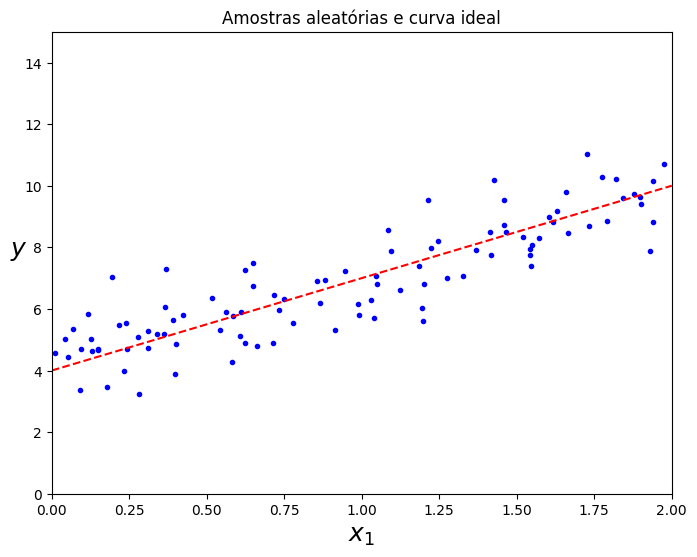

In [3]:
X_aux = np.array([[0.0], [2.0]])
y_aux = 4 + 3 * X_aux

plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.")
plt.plot(X_aux, y_aux, "r--")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.title('Amostras aleatórias e curva ideal')
plt.show()

Para usar a equação normal temos que aumentar a matriz de amostras de treinamento com uma coluna extra de valores $1$:

In [4]:
print(f'Tamanho original da matriz de amostras: {X.shape}')
print(f'Algumas das amostras originais:\n{X[:5]}')

Tamanho original da matriz de amostras: (100, 1)
Algumas das amostras originais:
[[0.74908024]
 [1.90142861]
 [1.46398788]
 [1.19731697]
 [0.31203728]]


In [5]:
# Adicionando uma coluna de 1s.
X_b = np.c_[np.ones((m, 1)), X]

print(f'Tamanho da matriz de amostras aumentada: {X_b.shape}')
print(f'Algumas das amostras da matriz aumentada:\n{X_b[:5]}')

Tamanho da matriz de amostras aumentada: (100, 2)
Algumas das amostras da matriz aumentada:
[[1.         0.74908024]
 [1.         1.90142861]
 [1.         1.46398788]
 [1.         1.19731697]
 [1.         0.31203728]]


Agora vamos usar a equação normal para calcular os parâmetros ótimos:

In [16]:
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[4.21509616],
       [2.77011339]])

Chegamos perto do resultado ideal!

**Atividade:** Mude o número de pontos de treinamento e veja se os parâmetros ótimos se aproximam dos parâmetros ideais.

**R**: Quanto mais pontos de treinamento, mais os parâmetros ajustados ótimos se aproximam dos parâmetros ideais. Para investigar melhor essa questão, vamos explorar como o valor ajustado se comporta dependendo do número de amostras de treinamento através de um gráfico, veja abaixo. (Nota: o eixo do número de amostras está em escala logarítmica.)

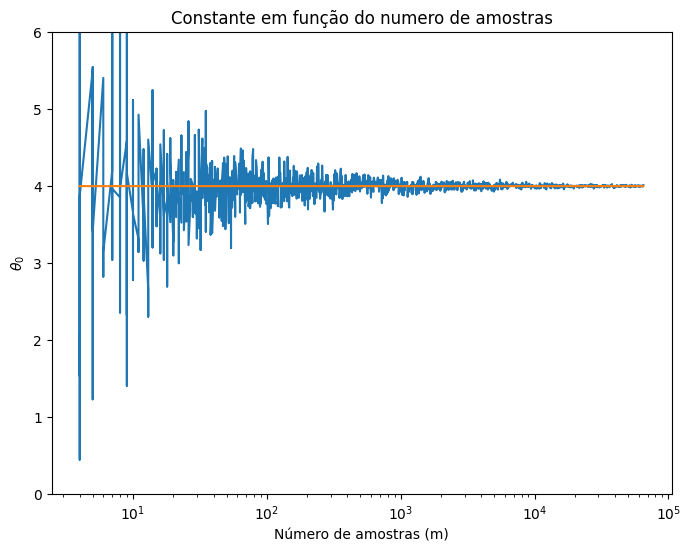

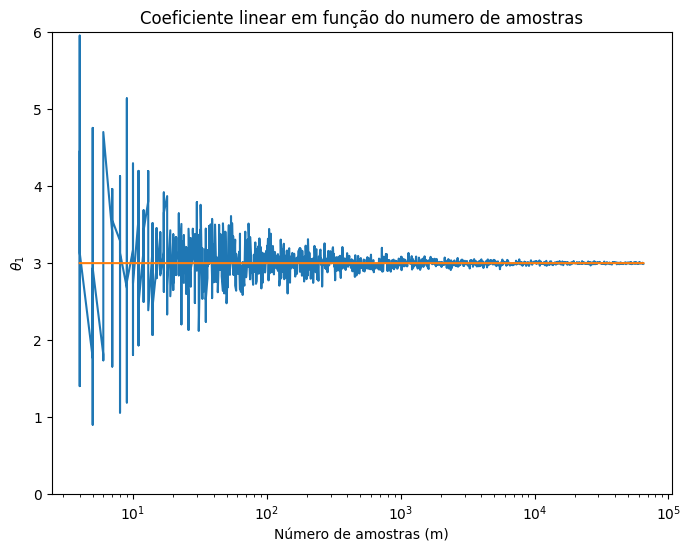

In [7]:
def experimento(m):
    # Gera o sinal ruidoso.
    X = 2 * np.random.rand(m, 1)
    ruido = np.random.randn(m, 1)
    y = 4 + 3 * X + ruido

    # Ajusta o modelo via equação normal.
    X_b = np.c_[np.ones((m, 1)), X]
    theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

    return theta_best


def roda_experimentos(range_m):
    constantes = []
    coefs = []
    for m in range_m:
        t = experimento(m)
        constantes.append(t[0])
        coefs.append(t[1])
    return constantes, coefs


def plot_figure(x, y, v, ylim, ylabel, t):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    plt.plot(x, v * np.ones(len(x)))
    plt.xlabel('Número de amostras (m)')
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.ylim(ylim)
    plt.title(t)
    plt.show()


range_m = list([int(2**k) for k in np.arange(2, 16, 0.01)])
constantes, coefs = roda_experimentos(range_m)

plot_figure(
    range_m,
    constantes,
    4.0,
    [0.0, 6.0],
    r'$\theta_0$',
    'Constante em função do numero de amostras',
)

plot_figure(
    range_m,
    coefs,
    3,
    [0.0, 6.0],
    r'$\theta_1$',
    'Coeficiente linear em função do numero de amostras',
)

Vamos ver como o modelo se comporta para fazer predições:

In [8]:
# Criando um vetor de amostras fictícias de teste.
X_test = np.linspace(0.0, 2.0, num=100).T

# Calculando os valores de y preditos nos valores de teste.
X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
y_pred = X_test_b.dot(theta_best)

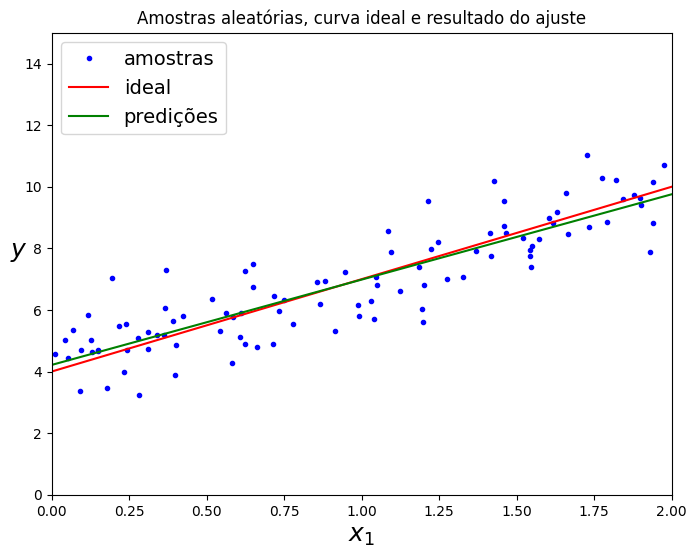

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.", label='amostras')
plt.plot(X_aux, y_aux, "r", label='ideal')
plt.plot(X_test, y_pred, "g-", label='predições')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.title('Amostras aleatórias, curva ideal e resultado do ajuste')
plt.show()

Vamos comparar nosso preditor com o regressor linear do scikit-learn:

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

Resultados identicos!

**Atividade:** Escreva seu próprio regressor linear no framework do scikit-learn. Teste o regressor.

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin


class NormalEquationLinearRegressor(BaseEstimator, RegressorMixin):

    def fit(self, X, y):
        X_b = np.c_[np.ones((m, 1)), X]
        self.theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

    def predict(self, X):
        X_b = np.c_[np.ones((len(X), 1)), X]
        y_pred = X_b.dot(self.theta_best)
        return y_pred

In [12]:
lin_reg_caseiro = NormalEquationLinearRegressor()
lin_reg_caseiro.fit(X, y)

In [13]:
lin_reg_caseiro.theta_best

array([[4.21509616],
       [2.77011339]])

In [14]:
y_pred = lin_reg_caseiro.predict(X_test)

In [15]:
lin_reg_caseiro.score(X, y)

0.7692735413614223

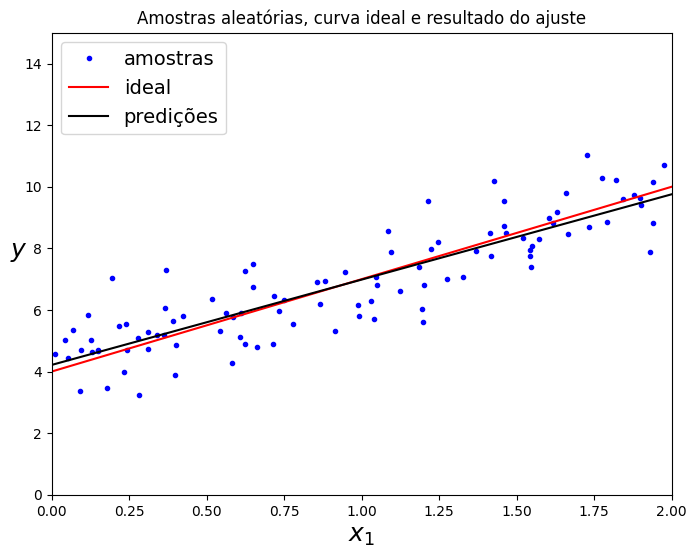

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.", label='amostras')
plt.plot(X_aux, y_aux, "r", label='ideal')
plt.plot(X_test, y_pred, "k-", label='predições')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.title('Amostras aleatórias, curva ideal e resultado do ajuste')
plt.show()

#  Gradient Descent

Um outro método de treinamento de uma regressão linear é o método do máximo declive (*gradient descent*). Este método também serve para outros regressores e classificadores, é bastante genérico - usaremos bastante o gradient descent em redes neurais!

Este método se baseia na observação seguinte:

- O gradiente da função de erro médio é um vetor no espaço de características que aponta na direção de maior crescimento do erro.
- Logo, se desejo achar os parâmetros que minimizam o erro, basta andar na direção contrária do gradiente do erro!

Ou seja, partindo de um "chute" aleatório $\mathbf{\theta}_{0}$ dos valores dos parâmetros, vamos iterativamente melhorar nossos parâmetros através de pequenos incrementos neste na direção oposta ao gradiente da função de erro:

$$
\mathbf{\theta}_{i + 1} = \mathbf{\theta}_{i} - \eta \nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}, \mathbf{y}, \mathbf{\theta}_{i}\right)
$$

O **hiperparâmetro** $\eta$ é chamado de *passo de aprendizado* (*learning step*) do algoritmo.

Continuamos iterando através desta fórmula até que não tenhamos mais mudanças significativas em $\mathbf{\theta}$, ou seja: para uma pequena tolerância $\epsilon > 0$

$$
\left| \, \mathbf{\theta}_{i + 1} - \mathbf{\theta}_{i} \, \right| < \epsilon
$$

O **hiperparâmetro** $\epsilon$ controla a precisão desejada na solução final. Se a tolerância for muito pequena pode ser que o algoritmo não convirja rapidamente. Neste caso é comum definir um número máximo de iterações através de outro **hiperparâmetro** ``max_iter``.

**Atividade:** Estude o material do livro texto (Géron), capítulo 4 e responda:

- Qual a diferença entre batch gradient descent, stochastic gradient descent, e mini-batch gradient descent?
- O que acontece quando $\eta$ é muito pequeno?
- O que acontece quando $\eta$ é muito grande?
- Quais as classes do scikit-learn que implementam regressão linear usando a equação normal no treinamento? Quais usam gradient descent em alguma de suas formas?

**R:**

Vamos implementar o método do *gradient descent* para resolver o problema do treinamento do modelo linear.

Vamos desenhar a discussão acima na forma de pseudo-código:

- Entrada: 
    - Conjunto de treinamento $(\mathbf{X}_{m \times n}, \mathbf{y}_{m \times 1})$
    - Valores iniciais do vetor de parâmetros $\theta$
    - Hiperparâmetros do algoritmo: 
        - tolerância $\epsilon$
        - número máximo de iterações $N_{\text{max}}$
        - taxa de aprendizado $\eta$
- Saida: 
    - Valores ótimos do vetor de parametros $\theta$

Algoritmo:

- $acabou \leftarrow Falso$
- $iter \leftarrow 0$
- enquanto não $acabou$:
    - $\theta_{novo} \leftarrow \theta - \eta \nabla_{\theta} \varepsilon^2\left(\mathbf{X}, \mathbf{y}, \theta\right)$
    - $iter \leftarrow iter + 1$
    - se $\left| \, \theta - \theta_{novo} \, \right| < \epsilon$ ou $iter > N_{\text{max}}$:
        - $acabou \leftarrow Verdadeiro$
    - $\theta \leftarrow \theta_{novo}$
- retorna $\theta$

**Atividade**: Implemente o algoritmo de *gradient descent* na forma de um modelo do Scikit-Learn e teste o resultado! Lembrando: 

$$
\nabla_{\theta} \varepsilon^2\left(\mathbf{X}, \mathbf{y}, \theta \right) = 
\frac{1}{m} (
    2 \mathbf{X}^{T} \mathbf{X} \mathbf{\theta} 
  - 2 \mathbf{X}^{T} \mathbf{y})
$$

sendo que a matriz $\mathbf{X}$ já contem o termo constante (aquela coluna de $1$s).

In [18]:
from numpy.linalg import norm


def gradient_mse(X, y, theta):
    m = X.shape[0]
    y_pred = X.dot(theta)
    erro = y_pred - y
    return (2.0 / m) * X.T.dot(erro)


def batch_gradient_descent(
    X,
    y,
    gradient=gradient_mse,
    n_max=100,
    tol=1e-3,
    eta=1e-3,
):
    m = X.shape[0]
    n = X.shape[1]
    theta = np.zeros((n + 1, 1))
    X_b = np.c_[np.ones((m, 1)), X]
    done = False
    i = 0
    status = []
    while not done:
        new_theta = theta - eta * gradient(X_b, y, theta)

        i += 1
        mag_diff = norm(new_theta - theta)
        status.append({'d': mag_diff, 'nt': new_theta})
        if (mag_diff < tol) or (i >= n_max):
            done = True

        theta = new_theta
    return theta, status

In [19]:
theta, status = batch_gradient_descent(X, y, n_max=1000, tol=1e-6, eta=0.1)
print(theta)
print(len(status))
for s in status:
    print(s)

[[4.21507534]
 [2.77013177]]
312
{'d': 2.010344562321678, 'nt': array([[1.36400082],
       [1.47681652]])}
{'d': 1.180566524412316, 'nt': array([[2.1774532 ],
       [2.33240552]])}
{'d': 0.6937888799584154, 'nt': array([[2.66730252],
       [2.82372075]])}
{'d': 0.40852396661361745, 'nt': array([[2.96677918],
       [3.10157963]])}
{'d': 0.2418148078793325, 'nt': array([[3.15410296],
       [3.25449858]])}
{'d': 0.1450968842838493, 'nt': array([[3.27520216],
       [3.3344241 ]])}
{'d': 0.0899929757787015, 'nt': array([[3.35704975],
       [3.37183677]])}
{'d': 0.05982291561532522, 'nt': array([[3.41549153],
       [3.3846172 ]])}
{'d': 0.044370841860779595, 'nt': array([[3.45984131],
       [3.38325025]])}
{'d': 0.03694496207309521, 'nt': array([[3.49557822],
       [3.3738799 ]])}
{'d': 0.03333245818733275, 'nt': array([[3.52593006],
       [3.36010241]])}
{'d': 0.03131800146948185, 'nt': array([[3.55280268],
       [3.34401891]])}
{'d': 0.02993388454584983, 'nt': array([[3.5773256

## Batch versus mini-batch versus stochastic gradient descent

O algoritmo acima chama-se *batch gradient descent*, pois opera com o lote (*batch*) completo de amostras de treinamento de uma vez só. Mas pense um pouco: será que precisamos de todas as amostras de treinamento para calcular um gradiente razoável? Considere os cenários a seguir:

- Calcular o gradiente do erro usando todas as amostras de um conjunto de treinamento com centenas de milhares de amostras.

- Calcular o gradiente do erro usando metade deste mesmo conjunto de treinamento.

Certamente o segundo caso não vai retornar o "melhor" gradiente, mas vai retornar algo muito próximo com um custo *MUITO* menor! Outra consideração, até mais importante: *O CONJUNTO DE TREINAMENTO PODE NEM CABER NA MEMÓRIA RAM*!

Este *insight* leva ao método *mini-batch gradient descent*: ao invés de trabalhar com o conjunto completo de treinamento de uma vez só, trabalhe com ele por pedaços, rotacionando o pedaço usado a cada iteração do algoritmo.

O algoritmo então fica assim:

- $acabou \leftarrow Falso$
- $epoch \leftarrow 0$
- enquanto não $acabou$:
    - $\theta_{novo} \leftarrow \theta$
    - Para cada *mini-batch* $(\mathbf{X}_{b}, \mathbf{y}_{b})$ de $(\mathbf{X}, \mathbf{y})$:
        - $\theta_{novo} \leftarrow \theta_{novo} - \eta \nabla_{\theta_{novo}} \varepsilon^2\left(\mathbf{X}_{b}, \mathbf{y}_{b}, \theta_{novo}\right)$
    - $epoch \leftarrow epoch + 1$
    - se $\left| \, \theta - \theta_{novo} \, \right| < \epsilon$ ou $epoch > N_{\text{max}}$:
        - $acabou \leftarrow Verdadeiro$
    - $\theta \leftarrow \theta_{novo}$
- retorna $\theta$

Cada passagem completa por todos os *mini-batches* (ou seja, um passo pelo *batch* completo) chama-se *epoch* no linguajar de machine learning.

No caso limite em que o tamanho do *mini-batch* é $1$ (!!!), mas a amostra é escolhida ao acaso (ao invés de passar por todas as amostras), temos o algoritmo *stochastic gradient descent*.

In [20]:
def mini_batch_gradient_descent(
    X,
    y,
    gradient=gradient_mse,
    n_max=100,
    tol=1e-3,
    eta=1e-3,
    batch_size=32,
):
    theta = np.zeros((2, 1))
    m = X.shape[0]
    num_batches = ((m - 1) // batch_size) + 1
    X_b = np.c_[np.ones((m, 1)), X]
    done = False
    epoch = 0
    while not done:
        new_theta = theta
        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
            if end > m:
                end = m
            X_batch = X_b[start:end, :]
            y_batch = y[start:end]
            new_theta = new_theta - eta * gradient(X_batch, y_batch, new_theta)
        epoch += 1
        mag_diff = norm(new_theta - theta)
        if (mag_diff < tol) or (epoch >= n_max):
            done = True
        theta = new_theta
    return theta


theta = mini_batch_gradient_descent(X, y, n_max=1000, tol=1e-6, eta=0.1)
theta

array([[4.3594589 ],
       [2.74329634]])



# Regressão polinomial

E se os dados não se ajustam a uma linha reta (ou um hiperplano, no caso geral)? Considere o seguinte problema:

In [21]:
np.random.seed(42)

# Vamos gerar m = 100 amostras de exemplo.
m = 100

# As coordenadas x são geradas aleatoriamente entre -3 e 3.
X = 6 * np.random.rand(m, 1) - 3

# Computando os valores de y
y = 0.5 * X**2 + X + 2

# Adicionando ruido.
y += 1.0 * np.random.randn(m, 1)

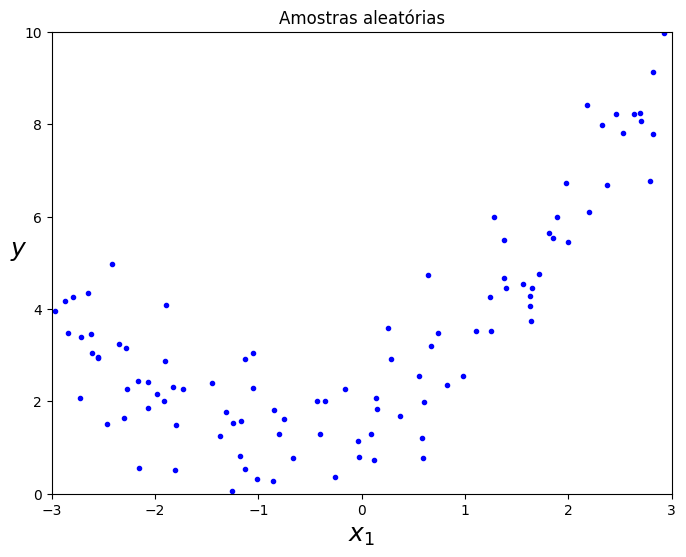

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.title('Amostras aleatórias')
plt.show()

Obviamente não podemos atingir um bom *fit* com uma linha reta! A solução para nosso problema é criar novas *features* com valores polinomiais:

In [23]:
print(f'Tamanho original da matriz de amostras: {X.shape}')
print(f'Algumas das amostras originais:\n{X[:5]}')

Tamanho original da matriz de amostras: (100, 1)
Algumas das amostras originais:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]


In [24]:
# Adicionando uma coluna de 1s e uma coluna de x**2.
X_b = np.c_[np.ones((m, 1)), X, X**2]

print(f'Tamanho da matriz de amostras aumentada: {X_b.shape}')
print(f'Algumas das amostras da matriz aumentada:\n{X_b[:5]}')

Tamanho da matriz de amostras aumentada: (100, 3)
Algumas das amostras da matriz aumentada:
[[ 1.         -0.75275929  0.56664654]
 [ 1.          2.70428584  7.3131619 ]
 [ 1.          1.39196365  1.93756281]
 [ 1.          0.59195091  0.35040587]
 [ 1.         -2.06388816  4.25963433]]


Usamos novamente a equação normal para achar os parâmetros ótimos (ou o gradient descent também serve!)

In [25]:
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[1.78134581],
       [0.93366893],
       [0.56456263]])

Agora vamos ver como ficou nosso *fit*:

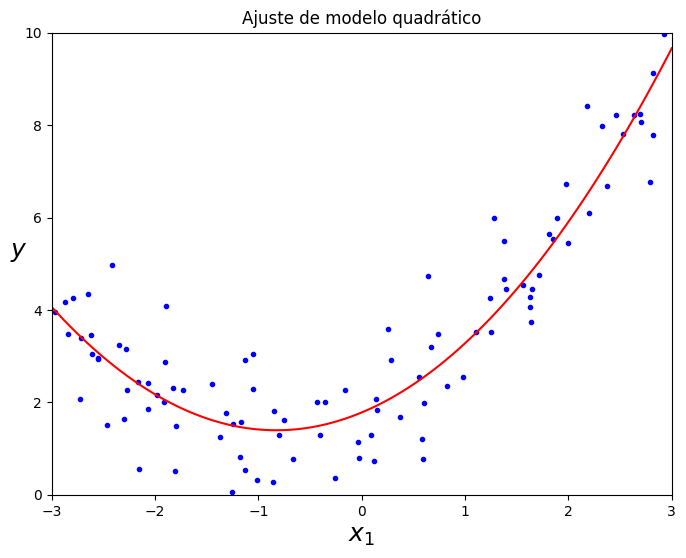

In [26]:
X_test = np.linspace(-3, 3, num=100).T
X_test_b = np.c_[np.ones((m, 1)), X_test, X_test**2]
y_test = X_test_b @ theta_best

plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.")
plt.plot(X_test, y_test, "r-")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.title('Ajuste de modelo quadrático')
plt.show()

Para criar *features* polinomiais de um grau qualquer em scikit-learn podemos usar a classe ``PolynomialFeatures``:

In [27]:
from sklearn.preprocessing import PolynomialFeatures

# Nota: include_bias=False porque o bias (termo constante) já estará incluso 
# no regressor linear.
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X.shape)
print(X_poly.shape)

(100, 1)
(100, 2)


In [28]:
print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


Podemos então fazer um regressor linear com estes novos dados:

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Compare os resultados obtidos aqui com aqueles da equação normal obtidos anteriormente.

Assim como o uso de *features* polinomiais leva a um modelo com melhor ajuste, podemos também usar outras funções como *features*, tais como $\text{log}()$, $\text{sin}()$, etc.

# Overfitting versus underfitting

O que acontece se o grau do *fit* polinomial for muito baixo? E se for muito alto? Vamos experimentar um pouco:

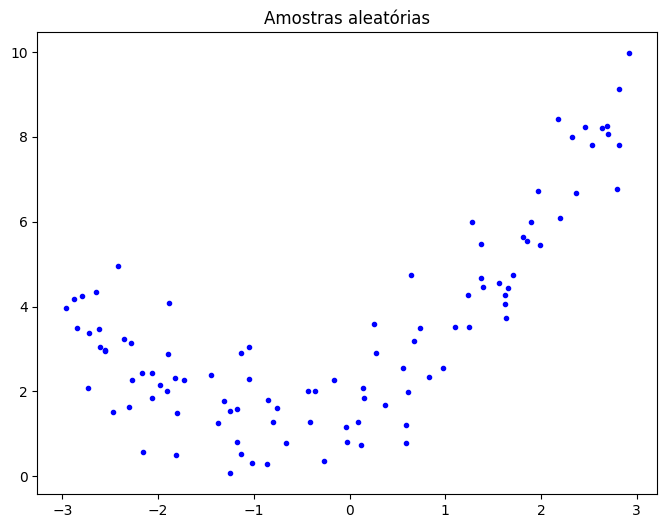

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.", linewidth=3)
plt.title('Amostras aleatórias')
plt.show()

In [31]:
def plot_model(X_test, y_test, degree):
    plt.figure(figsize=(8, 6))
    plt.plot(X, y, "b.", linewidth=3)
    plt.plot(X_test, y_test, 'r-', label=f'grau {degree}')
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.axis([-3, 3, 0, 10])
    plt.title(f'Modelo de grau {degree}')
    plt.show()

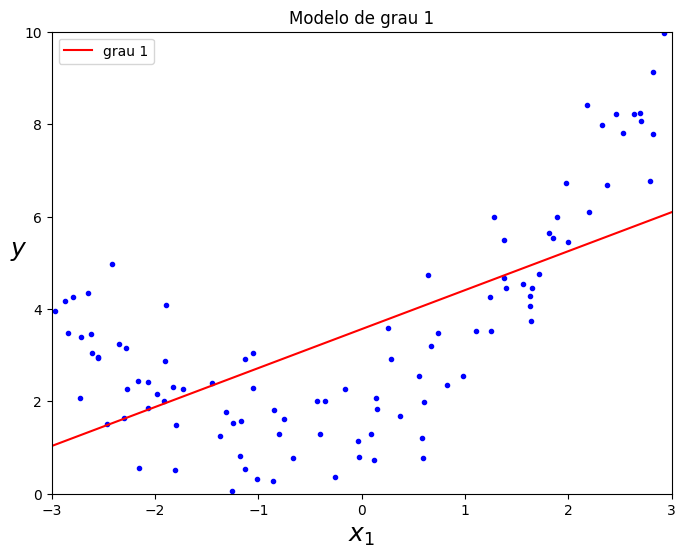

In [32]:
# Experimento 1: grau baixo.
poly_reg_1 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=1, include_bias=False)),
    ("std_scaler", StandardScaler()),
    ("lin_reg", LinearRegression()),
])
poly_reg_1.fit(X, y)
y_test_1 = poly_reg_1.predict(X_test.reshape(-1, 1))

plot_model(X_test, y_test_1, 1)

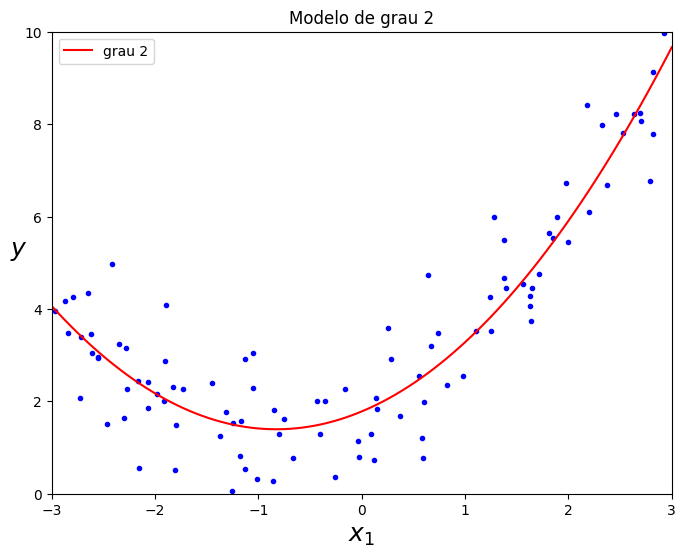

In [33]:
# Experimento 2: grau adequado.
poly_reg_2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("std_scaler", StandardScaler()),
    ("lin_reg", LinearRegression()),
])
poly_reg_2.fit(X, y)
y_test_2 = poly_reg_2.predict(X_test.reshape(-1, 1))

plot_model(X_test, y_test_2, 2)

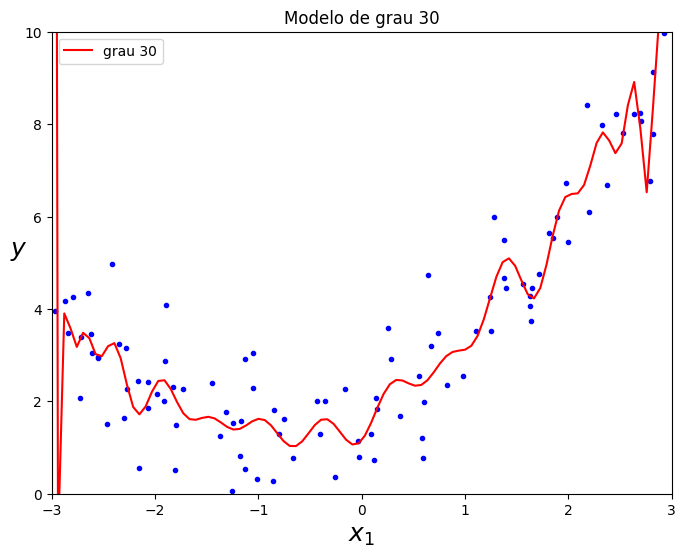

In [35]:
# Experimento 3: grau muito alto.
poly_reg_30 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=30, include_bias=False)),
    ("std_scaler", StandardScaler()),
    ("lin_reg", LinearRegression()),
])
poly_reg_30.fit(X, y)
y_test_30 = poly_reg_30.predict(X_test.reshape(-1, 1))

plot_model(X_test, y_test_30, 30)

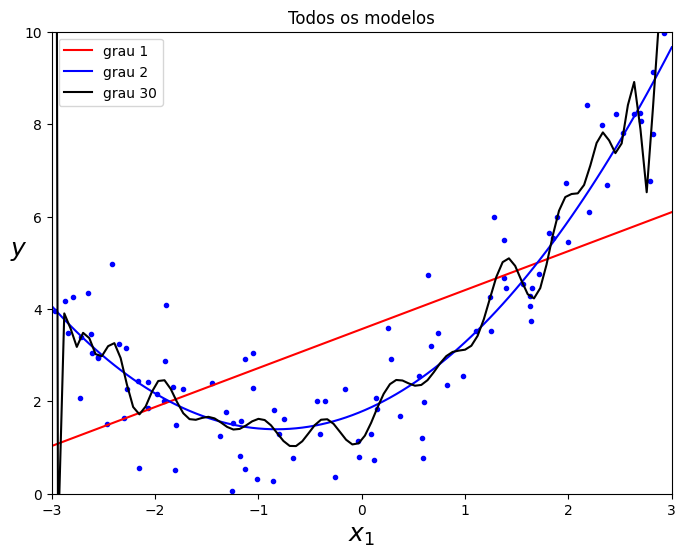

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(X, y, "b.", linewidth=3)
plt.plot(X_test, y_test_1, 'r-', label='grau 1')
plt.plot(X_test, y_test_2, 'b-', label='grau 2')
plt.plot(X_test, y_test_30, 'k-', label='grau 30')
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.title('Todos os modelos')
plt.show()

A curva preta, correspondente ao *fit* de grau 30, apresenta *overfitting*. Ao tentar se ajustar o melhor possível aos pontos de dados, a curva tende a apresentar comportamento exagerado fora destes. 

Uma característica marcante do *overfitting* é que o sistema perde sua capacidade de fazer predições de boa qualidade quando não está na vizinhança de um ponto de treinamento. Dizemos que o sistema não **generaliza** bem. Para observar a capacidade de generalização de um sistema podemos usar a estratégia de validação cruzada e obter uma medida mais realista do RMSE do classificador:

In [37]:
from sklearn.model_selection import cross_val_score


def experiment(reg, X, y, degree):
    scores = np.sqrt(-cross_val_score(
        reg,
        X,
        y,
        cv=5,
        scoring='neg_mean_squared_error',
    ))
    print(f'Fit de grau {degree}:')
    print(f'RMSE = {scores}')
    print(f'média = {scores.mean()}, std = {scores.std()}')


experiments = (
    (1, poly_reg_1),
    (2, poly_reg_2),
    (30, poly_reg_30),
)

for degree, regressor in experiments:
    experiment(regressor, X, y, degree)

Fit de grau 1:
RMSE = [1.86571015 1.61846216 1.82661634 1.62718083 1.78619243]
média = 1.744832382371205, std = 0.10278329304877643
Fit de grau 2:
RMSE = [0.72745407 0.91894263 1.05905595 0.90376746 0.96825693]
média = 0.9154954107199845, std = 0.10853789964899939
Fit de grau 30:
RMSE = [  1.66691713   1.46233782   1.40230787 285.93499663   1.2803192 ]
média = 58.34937573095981, std = 113.79287920374605


Note que o erro de treinamento conta uma história diferente:

In [38]:
from sklearn.metrics import mean_squared_error


def final_train_error(X, y, reg):
    reg.fit(X, y)
    y_pred = reg.predict(X)  # Sim, estou predizendo no conjunto de treinamento.
    return np.sqrt(mean_squared_error(y_pred, y))


def params_to_str(pipeline):
    aux = pipeline.named_steps['lin_reg']
    return 'intercept = {}, coefs = {}'.format(aux.intercept_, aux.coef_)


for degree, regressor in experiments:
    train_error = final_train_error(X, y, regressor)
    print(f'Fit de grau {degree}: RMSE = {train_error}')

for degree, regressor in experiments:
    print(f'Modelo de grau {degree}: {params_to_str(regressor)}')

Fit de grau 1: RMSE = 1.739127354922467
Fit de grau 2: RMSE = 0.8815858814376717
Fit de grau 30: RMSE = 0.7796341641080683
Modelo de grau 1: intercept = [3.41307859], coefs = [[1.49826128]]
Modelo de grau 2: intercept = [3.41307859], coefs = [[1.65818609 1.50762934]]
Modelo de grau 30: intercept = [3.41307839], coefs = [[ 4.91099226e+00  4.94688466e+01 -2.40069556e+02 -2.92828879e+03
   8.24032690e+03  7.58974882e+04 -1.47538704e+05 -1.08500871e+06
   1.54672559e+06  9.64547670e+06 -1.03275648e+07 -5.70609084e+07
   4.64884220e+07  2.34264109e+08 -1.46251694e+08 -6.84890558e+08
   3.28058953e+08  1.44526802e+09 -5.28055521e+08 -2.20664976e+09
   6.05550037e+08  2.41425905e+09 -4.82907229e+08 -1.84480994e+09
   2.54485111e+08  9.34703384e+08 -7.96625371e+07 -2.82096541e+08
   1.12148360e+07  3.83796618e+07]]


Podemos aqui observar uma característica marcante do *overfitting* versus *underfitting*:

- **overfitting**: 
    - O modelo é **complexo demais** (permite sobreajuste, ou *overfitting*)
    - erro de treinamento **baixo**
    - erro médio de teste **geralmente alto** (mas **ocasionalmente baixo**)
    - **variância alta** do erro de teste
    
- **underfitting**:
    - O modelo é **simples demais** (não permite bom ajuste)
    - erro de treinamento **alto**
    - erro de teste **consistentemente alto**
    - **variância baixa** do erro de teste

### Regressor ótimo

E agora, um pouco de Matemática!

Para um dado valor de $\mathbf{x}$, qual é o valor ideal de $h(\mathbf{x})$? Depende do que a gente define por "ideal". 

Vamos supor que a definição de "ideal" é dada pelo RMSE. Minimizar o RMSE é a mesma coisa que minimizar o MSE (Minimum Squared Error):

$$
\text{MSE} = \frac{1}{m} \sum_{i=1}^{m}\left(h(\mathbf{x}_i) - \mathbf{y}_i\right)^{2}
$$

Para atingir o mínimo do MSE devemos escolher uma $h(\mathbf{x})$ que minimize $(h(\mathbf{x}) - y)^2$ para qualquer valor dado de $\mathbf{x}$. Mas veja só o problema: se para um dado $\mathbf{x}$ só tivéssemos uma única possibilidade para $y$, o nosso problema estaria resolvido! Bastaria fazer o $h(\mathbf{x})$ valer aquele $y$ e pronto! Só que o mundo real tem incertezas, ruído e variabilidade na aquisição de nossos vários $\mathbf{x}_i$ e $y_i$, então não podemos afirmar categoricamente que para cada $\mathbf{x}$ só existirá um único $y$, eterno e imutável...

Pense assim: agora observamos que para um certo vetor $\mathbf{x}$ medido, também medimos um valor $y$. Só que na sequência medimos de novo um valor de $y$ para esse mesmo $\mathbf{x}$ e dá um valor um pouquinho diferente, por conta do ruído e outras incertezas!

Matematicamente, dizemos que cada uma de nossas amostras $(\mathbf{x}_i, y_i)$ foi obtida de um vetor aleatório (ou seja, um vetor de variáveis aleatórias) $(X, Y)$. Quando dizemos que existe incerteza em $y$ para um dado $\mathbf{x}$, estamos dizendo que existe uma distribuição aleatória de valores de $y$ para este valor de $\mathbf{x}$, ou seja, existe uma distribuição $P(Y | X=\mathbf{x})$.

Por exemplo, na figura a seguir temos uma situação em que foram observados os pontos em vermelho. Estes pontos foram gerados artificialmente assim:

- Foram escolhidos pontos $x$ ao acaso entre $0$ e $10$

- Para cada $x$ obtem-se um $y$ a partir de um polinomio de terceiro grau (curva em azul) ao qual se adicionou um valor aleatório amostrado de uma distribuição normal $N(\mu=0, \sigma=0.5)$.

- Os pontos assim obtidos estão desenhados em vermelho.

São dados *fake*, só para a gente estudar esse problema.

![Ilustração P(Y | X=x)](y_for_x.png "Ilustração P(Y | X=x)")

(Curiosamente, parece que a curva em azul é um excelente interpolador, ou seja, um candidato ideal para $h(\mathbf{x})$! Isso não é um acidente, e vamos provar isso logo a seguir!)

Vamos nos concentrar no valor $x = 6.2$, para efeito de exemplo. Qual a distribuição dos valores de $y$? Conforme visto no nosso processo artificial de geração dos pontos de exemplo, esperamos que a distribuição dos pontos de $y$ seja uma Gaussiana com média igual ao valor do polinômio azul ($4.48$), e desvio padrão valendo $0.5$. Isto está ilustrado na figura da direita.

Então a frase 

- "devemos minimizar $(h(\mathbf{x}) - y)^2$" 

não faz sentido (pois $y$ não é um valor único, é uma distribuição de valores), mas sim 

- "devemos minimizar $E_{Y | X = \mathbf{x}}[(h(X) - Y)^2]$"

onde o subscrito $Y | X = \mathbf{x}$ no operador de esperança indica que estamos obtendo o valor esperado da expressão $(h(X) - Y)^2$ em relação à variável aleatória $Y$, no caso em que a variável aleatória $X$ vale $\mathbf{x}$.

Para simplificar a notação, vamos chamar de $\hat{y} = h(\mathbf{x})$ o valor estimado de $y$ em $\mathbf{x}$. Vamos também chamar de $\overline{y}$ o valor esperado de $Y$ dado $X = \mathbf{x}$, ou seja, $\overline{y} = E_{Y | X = \mathbf{x}}[Y]$.

Temos o seguinte:

\begin{align*}
E_{Y | X = \mathbf{x}}[(h(X) - Y)^2] & = E_{Y | X = \mathbf{x}}[(h(\mathbf{x}) - Y)^2] 
& \,\, \text{(Pois $X$ vale $\mathbf{x}$)} \\
& = E_{Y | X = \mathbf{x}}[(\hat{y} - Y)^2]
& \,\, \text{(Pois $h(\mathbf{x}) = \hat{y}$)} \\
& = E_{Y | X = \mathbf{x}}[((\hat{y} - \overline{y}) - (Y - \overline{y}))^2]
& \,\, \text{(Subtraindo e somando $\overline{y}$)} \\
& = E_{Y | X = \mathbf{x}}[
    (\hat{y} - \overline{y})^2 
    + (Y - \overline{y})^2 
    - 2 (\hat{y} - \overline{y}) (Y - \overline{y})]
& \,\, \text{(Produto notável)} \\
& = E_{Y | X = \mathbf{x}}[(\hat{y} - \overline{y})^2] 
& \,\, \text{(Linearidade da esperança)} \\
& \phantom{ = }  + E_{Y | X = \mathbf{x}}[(Y - \overline{y})^2] \\
& \phantom{ = }  - 2 E_{Y | X = \mathbf{x}}[(\hat{y} - \overline{y}) (Y - \overline{y})] \\
& = (\hat{y} - \overline{y})^2 
& \,\, \text{(Pois $\hat{y}$ e $\overline{y}$ são constantes)} \\
& \phantom{ = }  + \text{Var}(Y | X = \mathbf{x})
& \,\, \text{(Definição de variância)} \\
& \phantom{ = }  - 2 (\hat{y} - \overline{y}) (E_{Y | X = \mathbf{x}}[Y] - \overline{y})
& \,\, \text{(Pois $\hat{y}$ e $\overline{y}$ são constantes)} \\
& = (\hat{y} - \overline{y})^2 + \text{Var}(Y | X = \mathbf{x})
& \,\, \text{(Pois $E_{Y | X = \mathbf{x}}[Y] - \overline{y} = 0$)} \\
\end{align*}

Lembre-se: nosso objetivo é definir qual o melhor valor de $\hat{y}$. Como nada se pode fazer sobre $\text{Var}(Y | X = \mathbf{x})$, só nos resta minimizar o termo $(\hat{y} - \overline{y})^2$. Isso é trivial: basta fazer $\hat{y} = \overline{y}$. Lembrando que $\hat{y} = h(\mathbf{x})$, chegamos ao nosso resultado final:

**O regressor que minimiza o valor esperado do RMSE é $h(\mathbf{x}) = \text{Média}(Y | X = \mathbf{x})$**

Ou seja, a melhor estimativa de $y$ em $\mathbf{x}$ é o valor médio de $y$ naquele ponto.

Lembra-se que eu disse na aula 2 que se a gente trocasse a função quadrado por módulo dava outro resultado? Pois fica aqui a afirmação (sem demonstração no momento) sobre o melhor regressor nessas condições:

**O regressor que minimiza o erro absoluto médio é $h(\mathbf{x}) = \text{Mediana}(Y | X = \mathbf{x})$**

### *Overfitting* e *underfitting* versus regressor ótimo

Agora que conhecemos o regressor ótimo, vamos compará-lo no dataset artificial acima aos regressores polinomiais de grau 1 (muito baixo), grau 3 (ideal, pois coincide com o regressor ótimo para este dataset artificial) e grau 8 (muito alto).

Geramos tres datasets diferentes para treinamento e um extra para teste, todos com a mesma estratégia acima (polinômio de grau 3, ao qual adicionamos ruido gaussiano).

#### Fit linear - underfitting

Vemos abaixo o resultado do fit linear para estes dados. As linhas sólidas coloridas representam o fit linear, enquando a linha tracejada preta demonstra o modelo ideal (o regressor ótimo).

![fit grau 1](fit_grau_1.png "fit grau 1")

Observe que todos os regressores lineares são próximos entre si, e todos falham em se ajustar bem aos dados por não terem liberdade suficiente para fazê-lo. Esta é uma característica do *underfitting*: os regressores ficam todos parecidos, e igualmente ruins.

#### Fit polinomial de grau 3 - perto do ideal

Vemos abaixo o resultado do ajuste polinomial de grau 3 para estes dados.

![fit grau 3](fit_grau_3.png "fit grau 3")

Observe que todos os regressores são próximos entre si, e também próximos do regressor ideal. Esta é uma caraterística que indica que estamos próximos do modelo de regressor ideal: todos os regressores ajustados são similares, e o erro de teste médio é o menor que se pode obter.

#### Fit polinomial de grau 8 - overfitting

Vemos abaixo o resultado do ajuste polinomial de grau 8 para estes dados.

![fit grau 1](fit_grau_8.png "fit grau 8")

Note que os vários regressores se ajustam bem aos pontos dos conjuntos de treinamento, mas diferem bastante entre si. Isto acontece justamente porque estes regressores se ajustaram tão bem aos dados de treinamento, incorporando a variabilidade de dados que se deve ao ruído, e não ao polinômio de grau 3 subjacente.

#### Comparação entre os modelos

Observe um *zoom* dos gráficos acima comparando os vários modelos:

![comparação](comparacao_fits.png "comparação entre fits")

---

**Atividade:**

Escreva, em suas palavras, uma análise comparativa simples entre os três cenários do gráfico de comparação acima.

**R:**

```
Ao comparar os três cenários do gráfico de comparação acima, podemos observar o seguinte:

Fit Linear (grau 1): Nesse cenário, o modelo de regressão linear de grau 1 apresenta um ajuste insuficiente aos dados. A linha de ajuste é uma reta simples, que não consegue capturar a complexidade do padrão subjacente nos dados. Isso é conhecido como "underfitting" ou ajuste insuficiente.

Fit Polinomial (grau 3): Nesse cenário, o modelo de regressão polinomial de grau 3 apresenta um ajuste próximo ao ideal. A linha de ajuste segue de perto o padrão dos dados, capturando a tendência geral. Os diferentes regressores polinomiais de grau 3 são semelhantes entre si e próximos do regressor ideal. Isso indica que estamos próximos do modelo ideal e o erro de teste médio é o menor possível.

Fit Polinomial (grau 8): Nesse cenário, o modelo de regressão polinomial de grau 8 apresenta um ajuste excessivo aos dados. Os diferentes regressores polinomiais de grau 8 se ajustam bem aos pontos de treinamento, mas diferem bastante entre si. Isso ocorre porque esses regressores se ajustaram tão bem aos dados de treinamento que incorporaram a variabilidade do ruído, em vez de capturar o padrão subjacente do polinômio de grau 3. Isso é conhecido como "overfitting" ou ajuste excessivo.

Em resumo, o ajuste linear de grau 1 é insuficiente, o ajuste polinomial de grau 3 é próximo ao ideal e o ajuste polinomial de grau 8 é excessivo. A escolha do grau do polinômio depende da complexidade dos dados e do equilíbrio entre o ajuste aos dados de treinamento e a capacidade de generalização para novos dados.

```

---

### *Bias/variance tradeoff*

Seja $\mathbf{D}$ um conjunto de treinamento de nosso modelo, com $m$ amostras de treinamento.

Primeiro, observamos o seguinte: para cada possível conjunto de treinamento $\mathbf{D}$ temos um vetor de parâmetros ótimos $\mathbf{\theta}_{\mathbf{D}}$ diferente, e consequentemente um modelo $h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})$ diferente. (Vimos isso acima quando obtemos regressores diferentes para conjuntos de treinamento diferentes.)

Logo, para um determinado valor de $\mathbf{x}$, temos que **$h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})$ é uma variável aleatória sobre o conjunto de todos os possíveis conjuntos de treinamento $\mathbf{D}$**.

Vamos definir a média e a variância desta variável aleatória (para um dado $\mathbf{x}$, não se esqueça) como:

$$
\mu_{h}(\mathbf{x}) = E_{\mathbf{D}}\left[h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})\right]
$$

e

$$
\sigma_{h}^2(\mathbf{x}) = E_{\mathbf{D}}\left[ \left(
    h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x}) - \mu_{h}(\mathbf{x})
\right)^2 \right]
$$

Respire, respire...

Agora vamos aos dados: vamos imaginar que nossos dados *observados* são da seguinte forma:

$$
(\text{valor observado}) = (\text{valor real}) + (\text{ruído e outros erros})
$$

Dando nomes aos bois, seja $y(\mathbf{x})$ o valor observado da variável dependente para uma amostra de entrada $\mathbf{x}$, $t(\mathbf{x})$ o valor real (true) da variável dependente, e $\varepsilon$ o ruído, que é uma variável aleatória independente de média zero e variância $\sigma_{\varepsilon}^2 = E\left[ \varepsilon^2 \right]$. Então a pseudo-equação acima fica sendo:

$$
y(\mathbf{x}) = t(\mathbf{x}) + \varepsilon
$$

Respire, respire...

Agora vamos juntar tudo. O erro entre o valor observado e o valor predito é

$$
y(\mathbf{x}) - h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})
$$

O erro quadrático é 

$$
\left(y(\mathbf{x}) - h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})\right)^2
$$

e - leia com calma - *o erro médio quadrático sobre todas as amostras de teste possíveis* ***e*** *para um dado conjunto de treinamento* é, portanto:

$$
\text{MSE}_{\mathbf{D}} = E_{\mathbf{x}}\left[\left(y(\mathbf{x}) - h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})\right)^2\right]
$$

Ainda sobrou uma incerteza no processo: o conjunto de treinamento $\mathbf{D}$. Nossa estimativa final de erro é o *valor esperado do erro quadrático médio $\text{MSE}_{\mathbf{D}}$ sobre todos os possíveis conjuntos de treinamento*, ou seja:

$$
\text{MSE} = E_{\mathbf{D}} \left[ E_{\mathbf{x}} \left[ 
\left(y(\mathbf{x}) - h_{\mathbf{\theta}_{\mathbf{D}}}(\mathbf{x})\right)^2
\right] \right]
$$

Podemos demonstrar que essa expressão pode ser escrita como:

$$
\text{MSE} = 
\underbrace{E_{\mathbf{x}} \left[ \left( t(\mathbf{x}) - \mu_{h}(\mathbf{x}) \right)^2 \right]}_{\text{bias}}
+ \underbrace{E_{\mathbf{x}} \left[ \sigma_{h}^2(\mathbf{x}) \right] }_{\text{variance}}
+ \underbrace{\sigma_{\varepsilon}^2}_{\text{erro intrínseco}}
$$

Ufa! Este é um resultado famoso de machine learning, conhecido como "Bias/Variance tradeoff". Representa o seguinte: para um regressor qualquer o MSE esperado é composto de três partes:

- *Bias* (ou viés): O termo $E_{\mathbf{x}} \left[ \left( t(\mathbf{x}) - \mu_{h}(\mathbf{x}) \right)^2 \right]$ é uma componente do erro que independe do conjunto de testes, e que mede a competência intrínseca do modelo. Modelos muito simples (*underfitting*) tem essa componente de viés alta, pois trata-se de um erro sistêmico.

- *Variance*: O termo $E_{\mathbf{x}} \left[ \sigma_{h}^2(\mathbf{x}) \right]$ representa a volatilidade do modelo em relação ao conjunto de testes usado. Modelos muito complexos (*overfitting*) tem essa componente do erro alta.

- Erro intrínseco: Esta componente do erro está relacionada com a qualidade do dado adquirido: quanto mais ruidoso, pior o desempenho ótimo do nosso sistema.

O qualificador *trade-off* vem do fato de que quando o *bias* aumenta, cai a *variance*, e vice versa. Existe um ponto de ótimo, contudo.

--- 

**Atividade:**

Explique, em termos de *bias*, *variance* e erro intrínseco, o comportamento do exemplo do polinômio de grau 3 acima, ou seja, explique a seguinte figura:

![comparação](comparacao_fits.png "comparação entre fits")


**R:**

```
A figura mostra a comparação entre diferentes ajustes polinomiais de grau 3 em um conjunto de dados. Vamos analisar o comportamento desses ajustes em termos de bias, variance e erro intrínseco.

Bias: O termo bias mede a competência intrínseca do modelo em se ajustar aos dados. Um modelo com alto bias é muito simples e não consegue capturar a complexidade dos dados. Por outro lado, um modelo com baixo bias é capaz de se ajustar bem aos dados. No exemplo, podemos observar que o ajuste polinomial de grau 3 tem um bias relativamente baixo, pois consegue se ajustar razoavelmente bem aos dados.

Variance: O termo variance representa a volatilidade do modelo em relação ao conjunto de dados de treinamento. Um modelo com alta variance é muito sensível aos dados de treinamento e pode se ajustar excessivamente a eles, resultando em um ajuste muito específico para aquele conjunto de dados específico. Por outro lado, um modelo com baixa variance é mais estável e generaliza melhor para novos dados. No exemplo, podemos observar que o ajuste polinomial de grau 3 tem uma variance relativamente alta, pois se ajusta muito bem aos dados de treinamento, mas pode não generalizar tão bem para novos dados.

Erro intrínseco: O erro intrínseco está relacionado à qualidade dos dados. Quanto mais ruidosos forem os dados, maior será o erro intrínseco. No exemplo, não temos informações específicas sobre o erro intrínseco dos dados.

Portanto, no exemplo do polinômio de grau 3, podemos dizer que o ajuste tem um bias relativamente baixo, pois consegue se ajustar bem aos dados, mas também tem uma variance relativamente alta, o que pode resultar em uma menor capacidade de generalização para novos dados.
```

---

## Curvas de aprendizado

O que quer dizer que um modelo é muito complexo? É um modelo que tem parâmetros de ajuste em excesso *em relação ao volume de dados de teste*. Um modelo tido como complexo para um conjunto pequeno de dados pode ser um modelo muito simples ao se considerar um conjunto maior de dados. Vamos explorar esse conceito em um experimento:

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def plot_learning_curves(model, X, y, ax1, ax2, step=5):
    # Separa 20% para validação.
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=RAND_SEED,
    )

    train_errors, val_errors = [], []

    # Para cada tamanho do conjunto de treinamento...
    for m in range(1, len(X_train)):
        mean_RMSE_train = 0.0
        mean_RMSE_val = 0.0

        count = 0
        for i in range(0, len(X_train) - m, step):
            # Ajusta modelo com apenas m amostras de treinamento.
            model.fit(X_train[i:(i + m)], y_train[i:(i + m)])

            # Faz a previsão sobre o conjunto de treinamento
            # (para obter o erro de treinamento)
            # e sobre o conjunto de validação.
            y_train_predict = model.predict(X_train[i:(i + m)])
            y_val_predict = model.predict(X_val)

            # Calcula o valor do RMSE
            RMSE_train = np.sqrt(
                mean_squared_error(
                    y_train_predict,
                    y_train[i:(i + m)],
                ))
            RMSE_val = np.sqrt(mean_squared_error(y_val_predict, y_val))

            mean_RMSE_train += RMSE_train
            mean_RMSE_val += RMSE_val
            count += 1

        mean_RMSE_train /= count
        mean_RMSE_val /= count

        # Armazena ambos os valores de RMSE.
        train_errors.append(mean_RMSE_train)
        val_errors.append(mean_RMSE_val)

    plt.figure(figsize=(8, 6))
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.axis(ax1)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

    plt.figure(figsize=(8, 6))
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.axis(ax2)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.show()

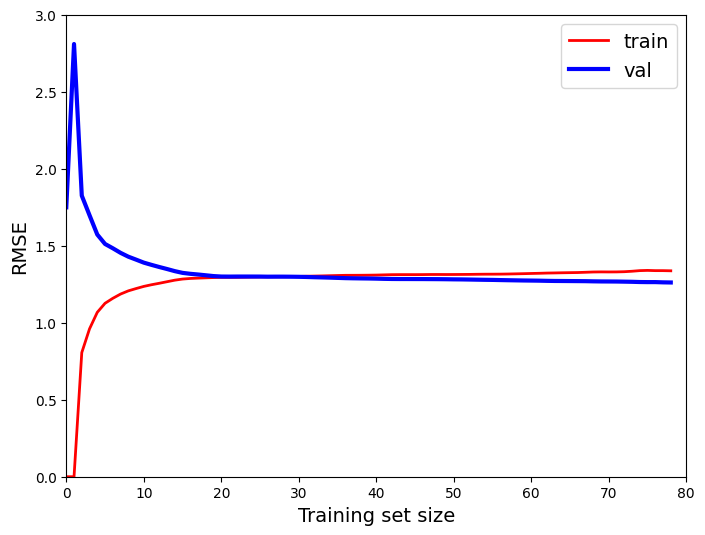

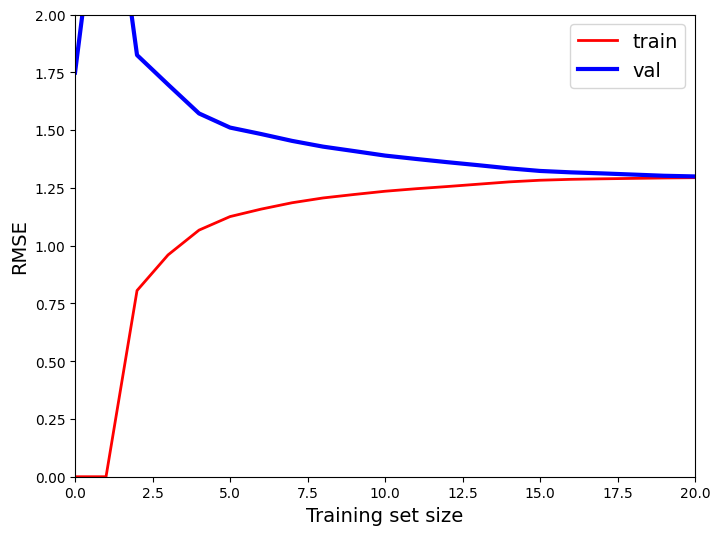

In [40]:
plot_learning_curves(poly_reg_1, X, y, [0, 80, 0, 3], [0, 20, 0, 2], 1)

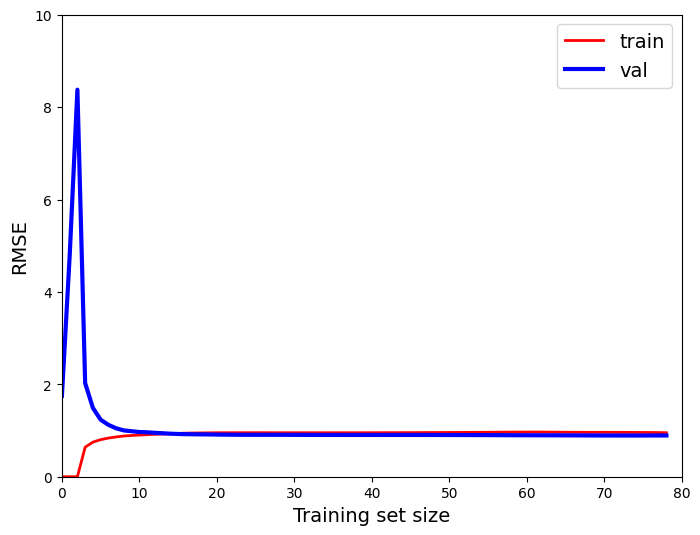

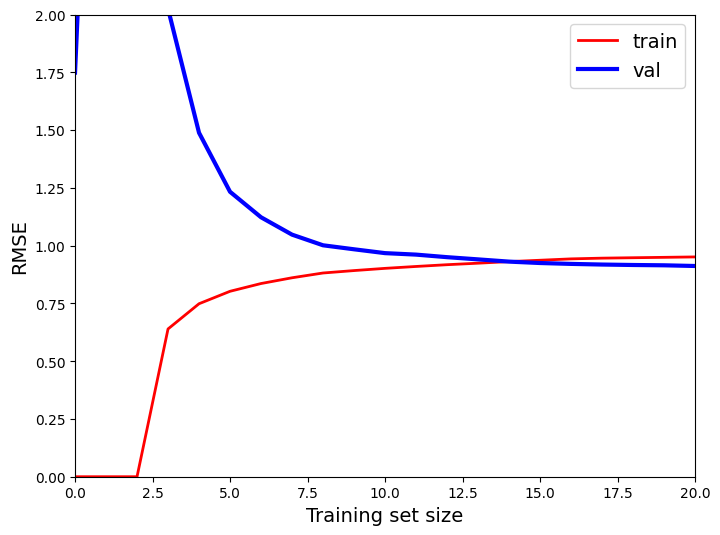

In [41]:
plot_learning_curves(poly_reg_2, X, y, [0, 80, 0, 1e1], [0, 20, 0, 2], 1)

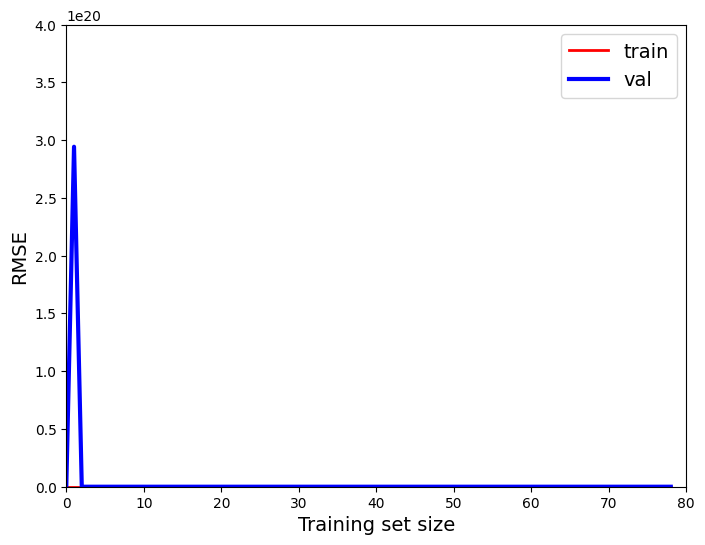

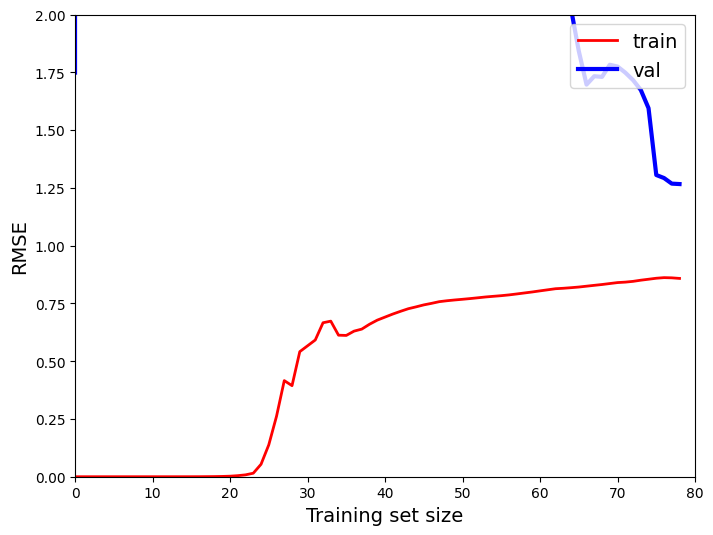

In [42]:
plot_learning_curves(poly_reg_30, X, y, [0, 80, 0, 4e20], [0, 80, 0, 2], 1)

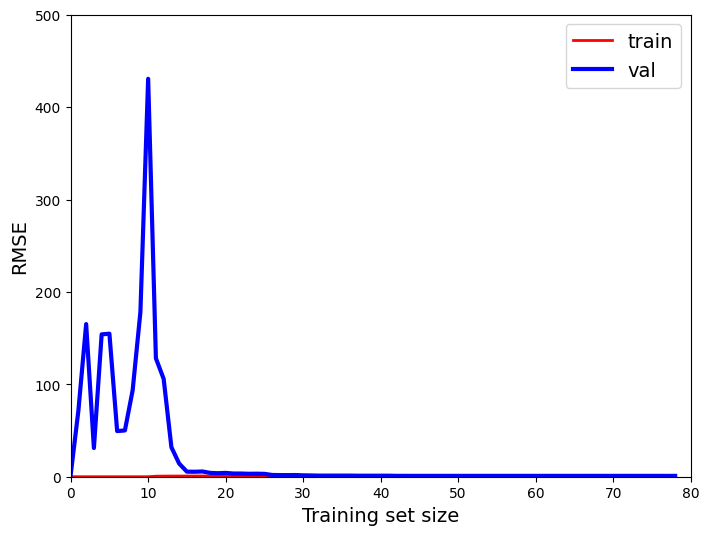

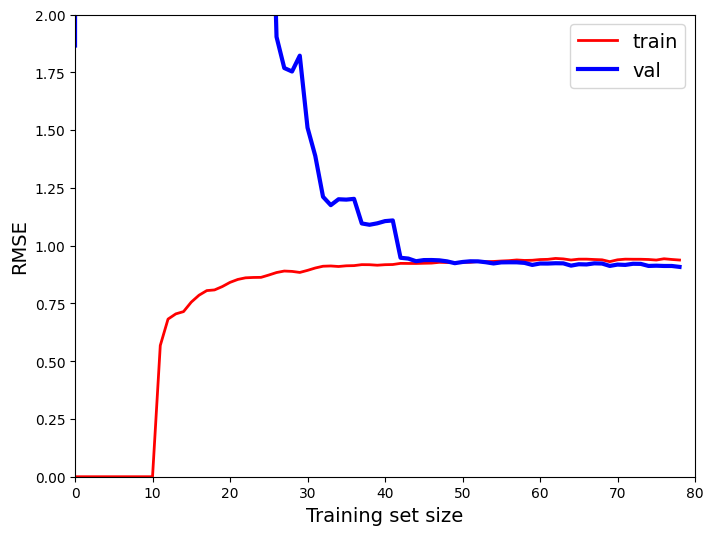

In [43]:
poly_reg_10 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("std_scaler", StandardScaler()),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(poly_reg_10, X, y, [0, 80, 0, 500], [0, 80, 0, 2])

Podemos observar quando um ajuste passa de *overfit* para ajuste normal conforme o número de dados de treinamento aumenta!

---

**Atividade:**

Explique:

- Porque o erro do modelo ``poly_reg_1`` é maior que o erro do modelo ``poly_reg_2``?

- Porque o erro do modelo ``poly_reg_30`` é maior que o erro do modelo ``poly_reg_2``?

- Porque na curva RMSE versus tamanho do conjunto de treinamento observamos, para o modelo de grau 10, que o erro de treinamento é zero até que o conjunto de treinamento tenha mais de 10 amostras?

- Para as curvas relacionadas a modelos complexos, eventualmente o erro tende a aproximadamente $\text{RMSE} = 1$ neste problema-exemplo. Explique em termos de *bias*, variância, e erro intrínseco. (Compare com os dados originais.)

**R:**

```
O erro do modelo poly_reg_1 provavelmente é maior que o erro do modelo poly_reg_2 porque poly_reg_1 é um modelo mais simples (um polinômio de grau 1, ou seja, um modelo linear) e pode não ser capaz de capturar a complexidade dos dados tão bem quanto poly_reg_2 (um polinômio de grau 2). Este é um caso de alto viés, onde as suposições do modelo são muito simples para modelar os dados com precisão.

O erro do modelo poly_reg_30 provavelmente é maior que o erro do modelo poly_reg_2 porque poly_reg_30 é um modelo muito mais complexo (um polinômio de grau 30) e pode estar superajustando os dados. O superajuste ocorre quando um modelo é muito complexo e começa a modelar o ruído nos dados, levando a uma alta variância. Isso significa que, embora o modelo possa se ajustar muito bem aos dados de treinamento, ele pode não generalizar bem para dados não vistos.

O RMSE (Root Mean Square Error) é zero para o modelo de grau 10 até que o conjunto de treinamento tenha mais de 10 amostras porque um polinômio de grau 10 pode se ajustar perfeitamente a 10 pontos. Isso ocorre porque um polinômio de grau n tem n+1 parâmetros, que podem ser ajustados para se ajustar exatamente a n+1 pontos. No entanto, à medida que mais pontos de dados são adicionados, o modelo não pode mais se ajustar a todos os pontos exatamente, e o RMSE começa a aumentar.

Para modelos complexos, o erro eventualmente tende a aproximadamente RMSE = 1 neste problema-exemplo por causa do trade-off entre viés e variância. À medida que a complexidade do modelo aumenta, o viés diminui, mas a variância aumenta. Em algum momento, o aumento na variância supera a diminuição no viés, levando a um aumento no erro total. O RMSE = 1 poderia ser o erro intrínseco nos dados, que é o erro que não pode ser reduzido, não importa quão bom seja o modelo, porque é devido ao ruído ou aleatoriedade nos dados que não pode ser modelado.
```


---